# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [16]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
from skimage import filters

# File sorting

`*` matches 0 or more characters.

In [2]:
file_list = glob('/nvme0/fwi-reanalysis/ECMWF_FWI_20*_1200_hr_fwi_e5.nc')

A sample of file names.

In [3]:
file_list[:3]

['/nvme0/fwi-reanalysis/ECMWF_FWI_20200307_1200_hr_fwi_e5.nc',
 '/nvme0/fwi-reanalysis/ECMWF_FWI_20191016_1200_hr_fwi_e5.nc',
 '/nvme0/fwi-reanalysis/ECMWF_FWI_20191206_1200_hr_fwi_e5.nc']

Sorting files by time to get deterministic order after loading.

In [3]:
files = sorted(file_list, key=lambda x: int(x[-22:-20])*100 + int(x[-20:-18]))

*Data is expected to be for 12 months*

In [19]:
len(files)

366

Saving the files in a separate location (once) to prevent unintended modification of original dataset. `shutil` allows efficient file operation by using shell commands under the hood.

In [20]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-reanalysis')

# Preprocessing

Taking a look at data. `xarray` contains `open_dataset` function to lazy load the contents of the file. `h5netcdf` engine gives faster I/O compared to the default `netcdf4`.

In [21]:
xr.open_dataset(files[0], engine='h5netcdf')

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01
  * lon      (lon) float32 0.0 0.28125 0.5625 ... 359.15625 359.4375 359.71875
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Wed Jun 03 12:12:44 2020: cdo --silent -select,name=fw...
    Reference date:    20200101
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

Each file contains the actual observation along with 9 day forecast.

Selecting only the actual value for the task at hand. `isel` method allows selecting data by index slice.

In [4]:
def preprocess(d):
    return d.isel(time=slice(0,1))

Combining multiple files into single dataarray.

In [5]:
proc = xr.open_mfdataset(files, preprocess=preprocess, engine='h5netcdf').sortby("time")

Taking a look.

In [24]:
proc

,Array,Chunk
Bytes,1.20 GB,3.28 MB
Shape,"(366, 640, 1280)","(1, 640, 1280)"
Count,1098 Tasks,366 Chunks
Type,float32,numpy.ndarray


**Pixel resolution**: *2560x5120*<br>
**Longitude resolution**: 0.0703125<br>
**Latitude resolution**: 0.06971<br>
*Should match with fwi-forcings to not require interpolation*

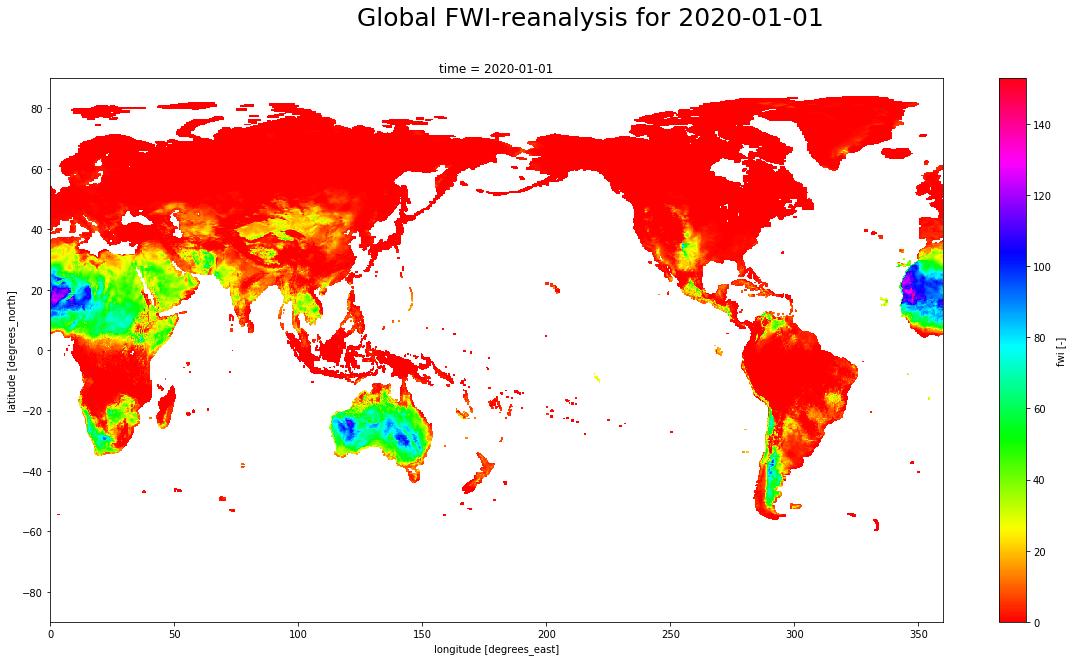

In [30]:
plt.figure(figsize = (20,10)).suptitle('Global FWI-reanalysis for 2020-01-01', fontsize=25)
proc.fwi[0].plot(cmap='hsv')

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [31]:
np.isnan(proc.fwi[0].values).any()

True

Printing general stats. During calculation, the NaN values are skipped using `skipna` parameter.

In [13]:
def npstats(x):
    tmp = np.nanmean(x)
    print('mean', tmp)
    print('mad', np.nanmean(np.abs(x-tmp)))
    print('var', np.nanvar(x))
    print('min', np.nanmin(x))
    print('max', np.nanmax(x))    

In [8]:
def stats(x):
    tmp = x.mean(skipna=True).values
    print('mean', tmp)
    print('mad', abs(x-tmp).mean(skipna=True).values)
    print('var', x.var(skipna=True).values)
    print('min', x.min(skipna=True).values)
    print('max', x.max(skipna=True).values)

In [33]:
stats(proc.fwi)

mean 15.292629
mad 18.819166
var 621.65894
min 1.7216163e-09
max 304.7236


In [27]:
proc.fwi.sel(time=np.datetime64("2019-04-02"))

<xarray.DataArray 'fwi' (lat: 640, lon: 1280)>
dask.array<getitem, shape=(640, 1280), dtype=float32, chunksize=(640, 1280), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * lon      (lon) float32 0.0 0.28125 0.5625 ... 359.15625 359.4375 359.71875
    time     datetime64[ns] 2019-04-02
Attributes:
    units:    -
    title:    Fire Weather Index

In [47]:
np.isnan(proc.fwi.sel(time=np.datetime64("2019-04-02")).values[355:480, 400:550])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
for i in range(366):
    print(i, end=' ')
    if (proc.fwi.values[0] == proc.fwi[275].values).all():
        print("match")
        break

0 1 2 3 4 5 6 7 

In [12]:
(proc.fwi.values[0] == proc.fwi[0].values)[~np.isnan(proc.fwi.values[0])].all()

True

In [18]:
proc.fwi[334]

<xarray.DataArray 'fwi' (lat: 640, lon: 1280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * lon      (lon) float32 0.0 0.28125 0.5625 ... 359.15625 359.4375 359.71875
    time     datetime64[ns] 2020-02-29
Attributes:
    units:    -
    title:    Fire Weather Index

In [424]:
import matplotlib.patches as mpatches

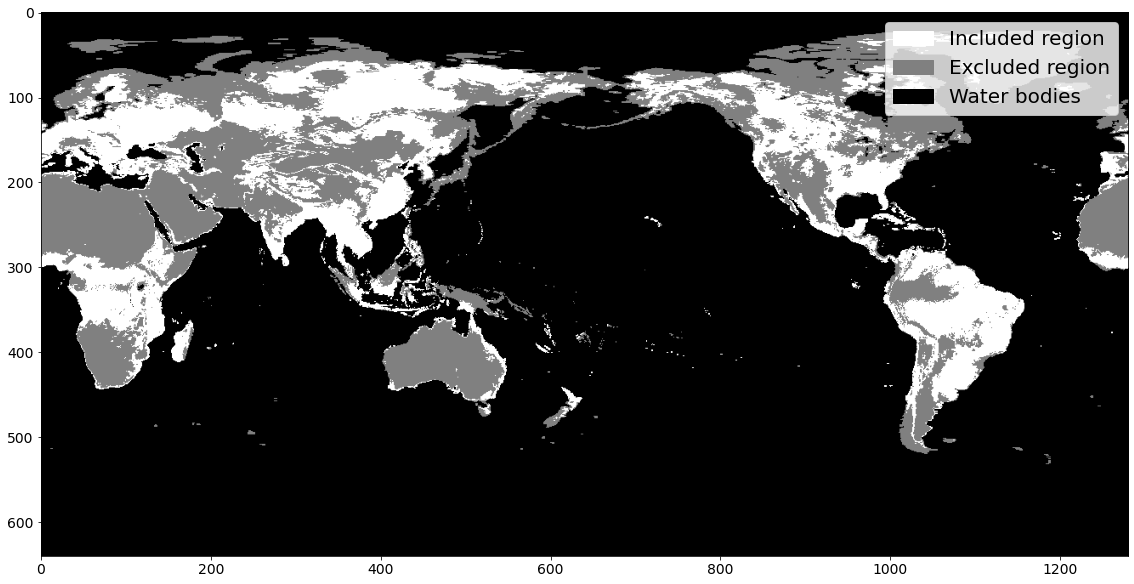

In [440]:
plt.imshow(week_long_fire.astype(float) + (~np.isnan(proc.fwi.values[0])).astype(float), cmap='gray')
colors = ["white", "gray", "black"]
lbl = ['Included region', 'Excluded region', 'Water bodies']
patches = [ mpatches.Patch(color=colors[i], label=lbl[i]) for i in range(3) ]
plt.legend(handles=patches, fontsize=20)
plt.tick_params(labelsize=14)

/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


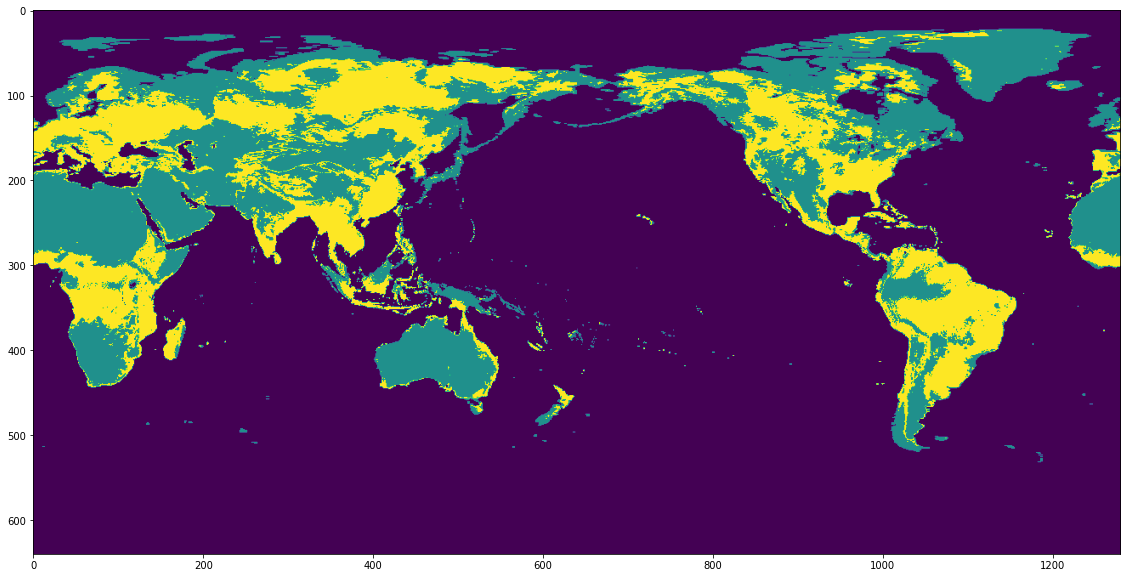

In [433]:
fire_event_mask = (proc.fwi.values < 80).prod(axis=0, keepdims=True) & (proc.fwi.values > 10)
week_long_fire = np.zeros(fire_event_mask.shape[1:], dtype=bool)
for i in range(6, fire_event_mask.shape[0]-7):
    for j in range(7):
        week_long_fire |= (fire_event_mask[i-6+j:i+j+1].sum(axis=0) == 7)
plt.figure(figsize=(20, 10))
plt.imshow(week_long_fire.astype(float) + (~np.isnan(proc.fwi.values[0])).astype(float))

In [96]:
import regionmask

In [272]:
countries = regionmask.defined_regions.natural_earth.countries_50

In [274]:
lon = proc.fwi.lon.values
lat = proc.fwi.lat.values
c_mask = countries.mask(lon, lat)

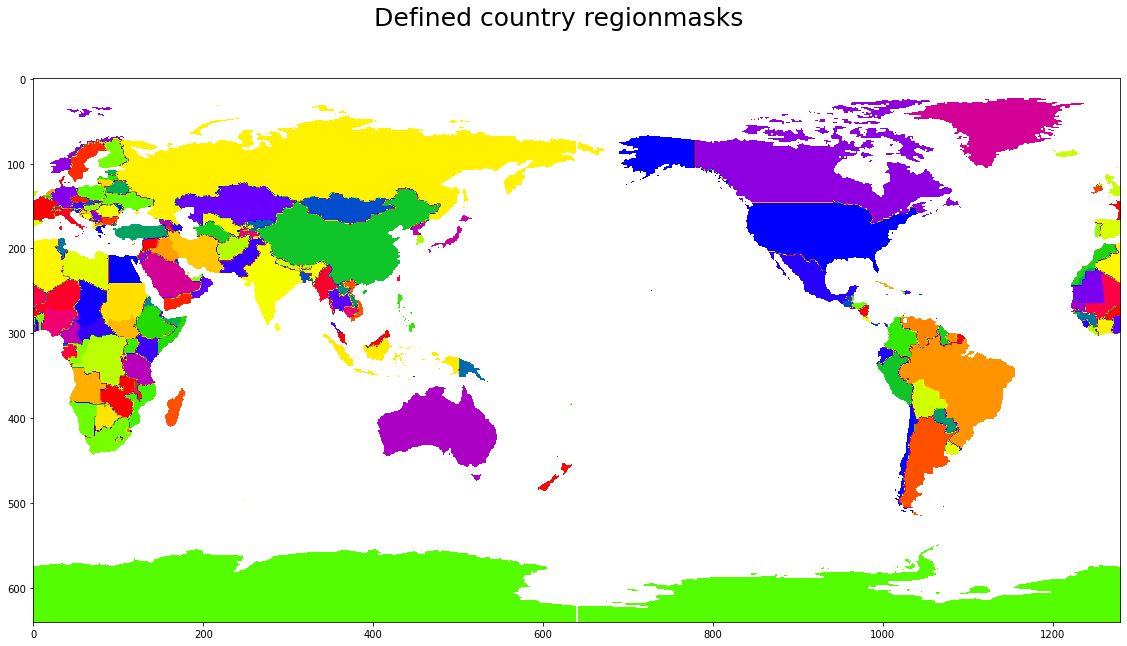

In [435]:
plt.figure(figsize = (20,10)).suptitle('Defined country regionmasks', fontsize=25)
plt.imshow(c_mask.values, cmap='prism')

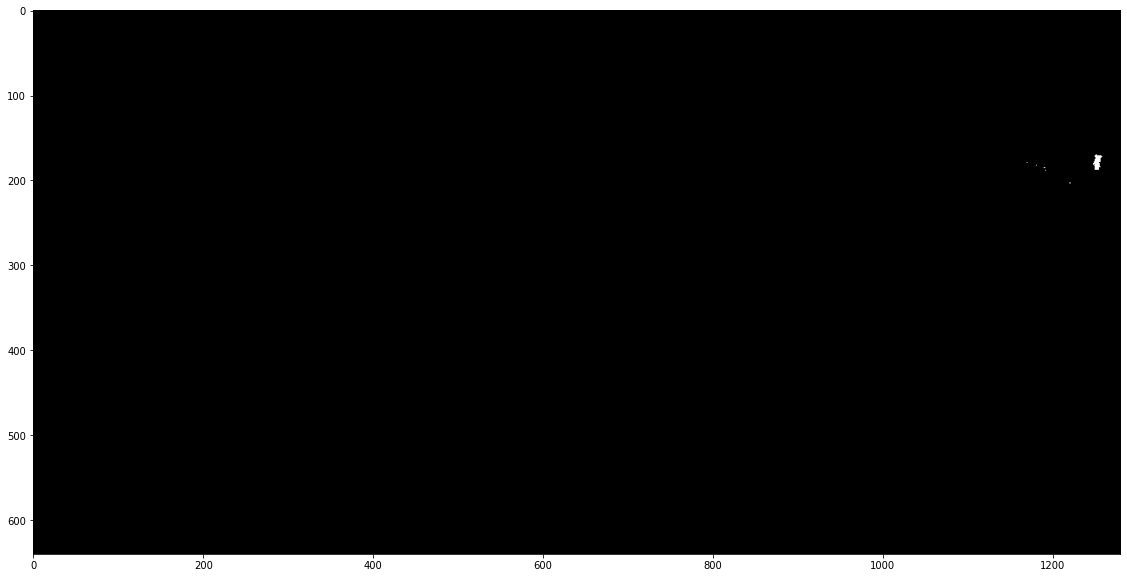

In [370]:
plt.figure(figsize = (20,10)).suptitle('Defined country regionmasks', fontsize=25)
pt_mask = (c_mask==regionmask.defined_regions.natural_earth.countries_50.names.index("Portugal")).values & (~np.isnan(proc.fwi[0]))
plt.imshow(pt_mask, cmap='gray')

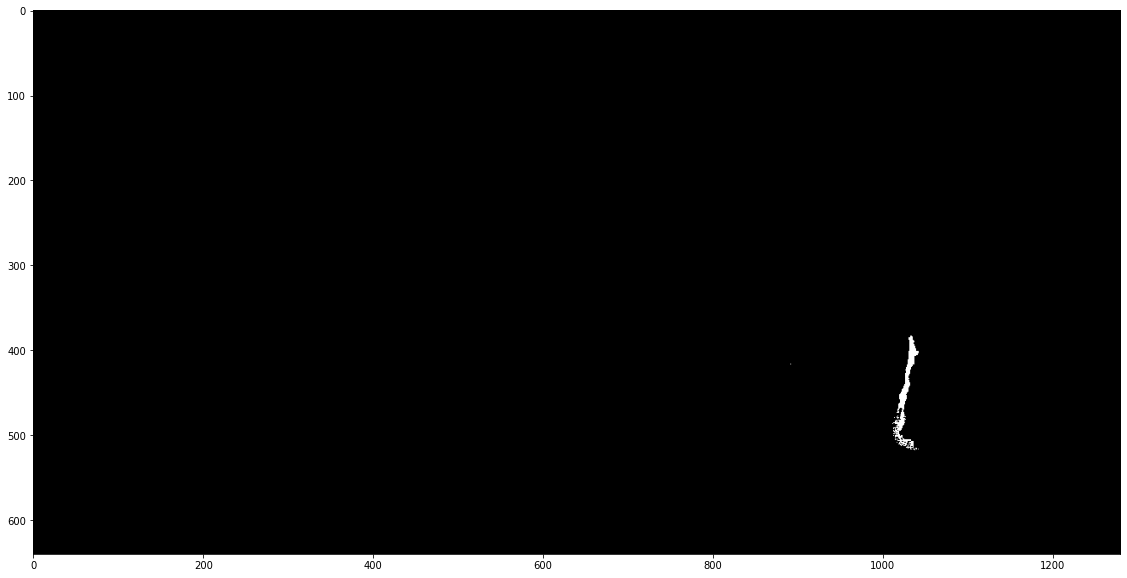

In [371]:
ch_mask = (c_mask==regionmask.defined_regions.natural_earth.countries_50.names.index("Chile")).values & (~np.isnan(proc.fwi[0]))
plt.imshow(ch_mask, cmap='gray')

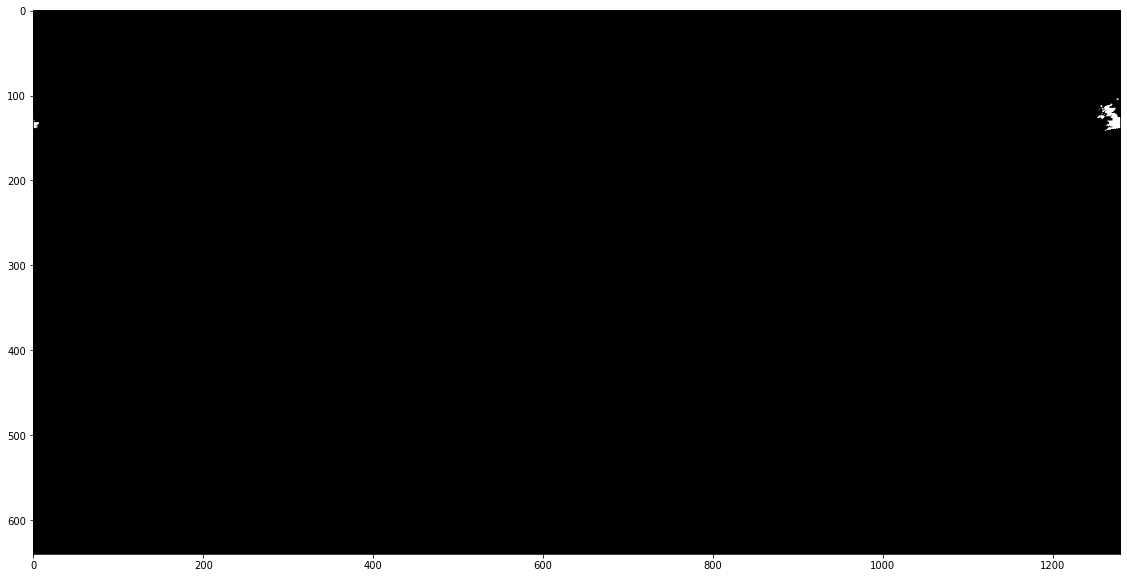

In [372]:
uk_mask = (c_mask==regionmask.defined_regions.natural_earth.countries_50.names.index("United Kingdom")).values & (~np.isnan(proc.fwi[0]))
plt.imshow(uk_mask, cmap='gray')

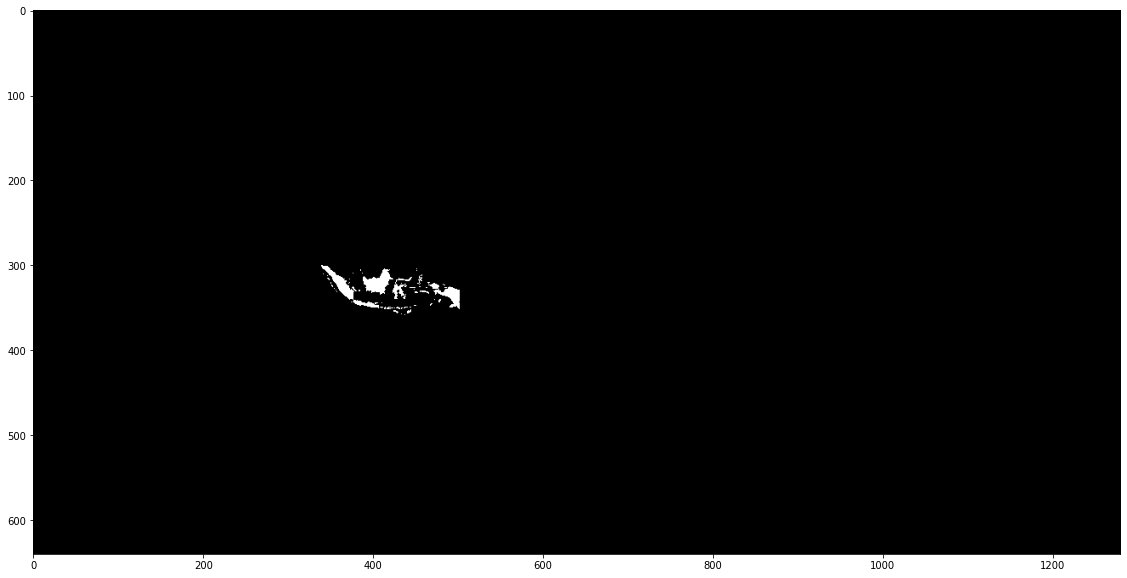

In [378]:
in_mask = (c_mask==regionmask.defined_regions.natural_earth.countries_50.names.index("Indonesia")).values & (~np.isnan(proc.fwi[0]))
plt.imshow(in_mask, cmap='gray')

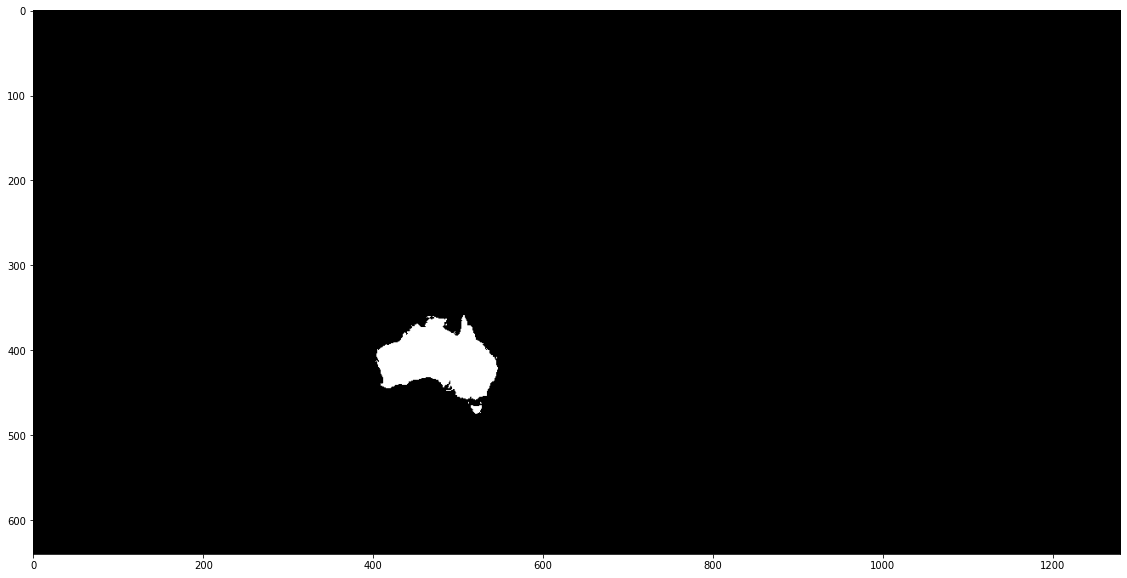

In [379]:
au_mask = (c_mask==regionmask.defined_regions.natural_earth.countries_50.names.index("Australia")).values & (~np.isnan(proc.fwi[0]))
plt.imshow(au_mask, cmap='gray')

In [280]:
us_states = regionmask.defined_regions.natural_earth.us_states_50

In [281]:
lon = proc.fwi.lon.values
lat = proc.fwi.lat.values
us_mask = us_states.mask(lon, lat)

In [406]:
im._rgbacache

AttributeError: 'AxesSubplot' object has no attribute '_rgbacache'

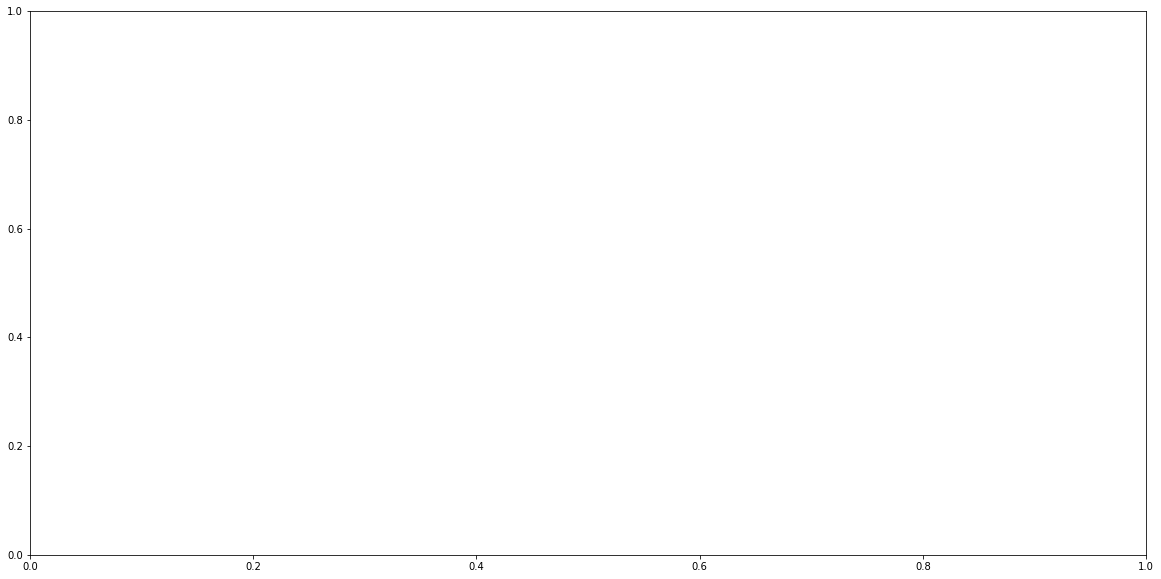

In [414]:
plt.gca()._rgbacache

In [409]:
plt.figure._rgbacache

AttributeError: 'function' object has no attribute '_rgbacache'

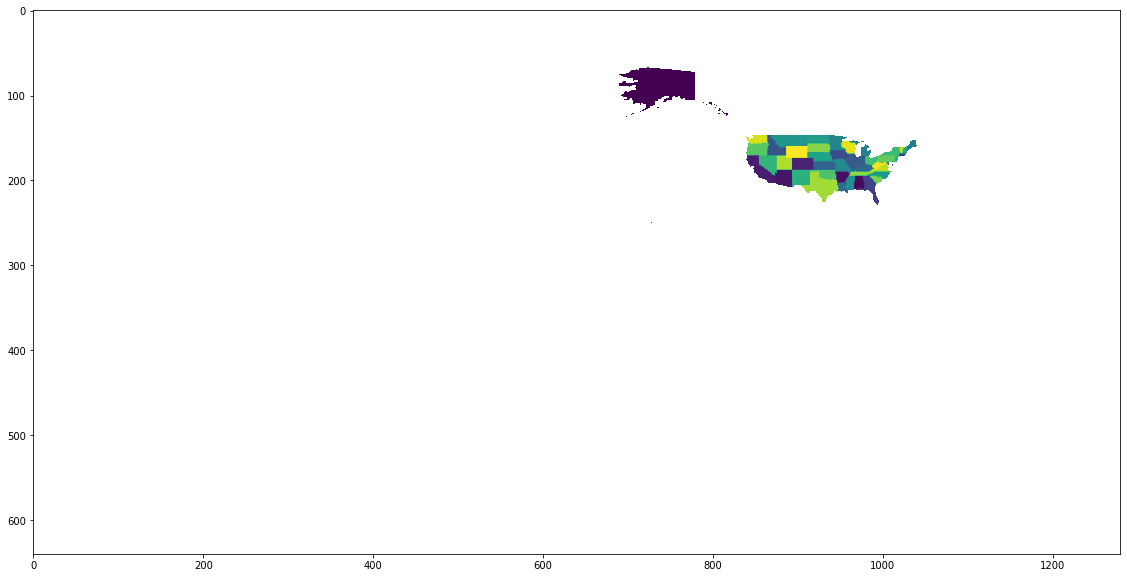

In [405]:
im = plt.imshow(us_mask.values)

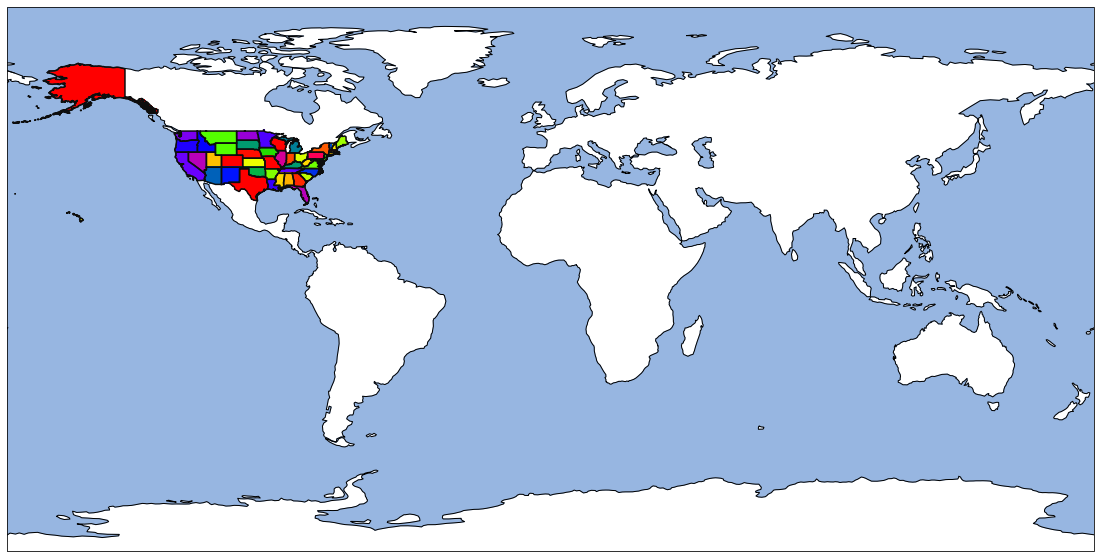

In [330]:
us_states.plot(add_label=False)
us_mask.plot(cmap='prism', add_colorbar=False)

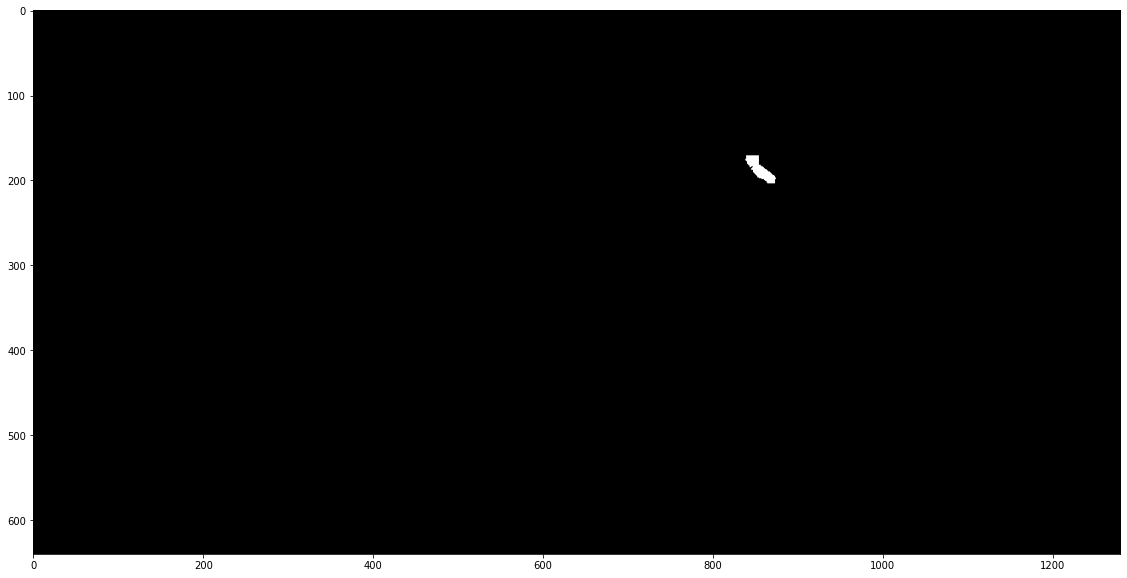

In [369]:
ca_mask = (us_mask==regionmask.defined_regions.natural_earth.us_states_50.names.index("California")).values & (~np.isnan(proc.fwi[0]))
plt.imshow(ca_mask, cmap='gray')

In [305]:
amazon_bound = np.array([[-76.82147, 0.3537], [-78.54253, -3.73634], [-78.01609, -5.74086], [-76.67973, -7.52266], [-74.97893, -10.53958], [-72.71118, -12.60484], [-69.61328, -14.20442], [-67.18355, -16.5329], [-64.45011, -17.68702], [-63.47822, -18.80065], [-60.60304, -18.76015], [-58.09232, -17.62628], [-58.03158, -14.16392], [-56.29027, -13.63748], [-53.13163, -13.0098], [-51.1271, -10.17512], [-50.43868, -7.17845], [-49.00109, -3.25039], [-50.49942, 0.47519], [-52.4432, 4.54498], [-58.05182, 6.93421], [-62.12162, 8.06809], [-66.7786, 6.36728], [-74.16902, 3.04665], [-76.82147, 0.3537]])

In [306]:
amazon_region = regionmask.Regions([amazon_bound], names=["amazon"], abbrevs=["A"], name="reg")

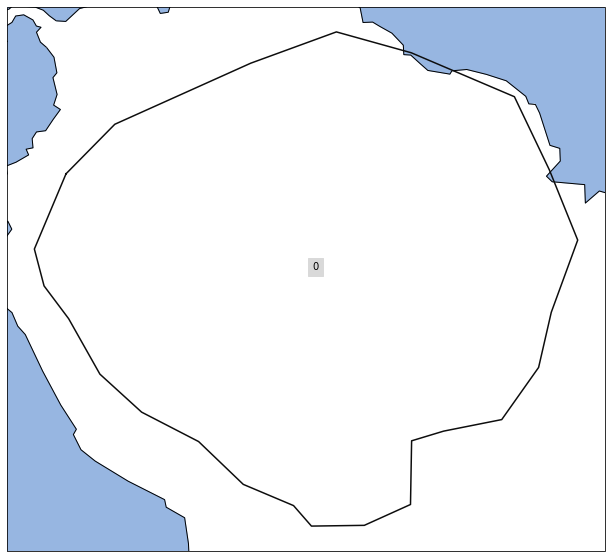

In [307]:
amazon_region.plot()

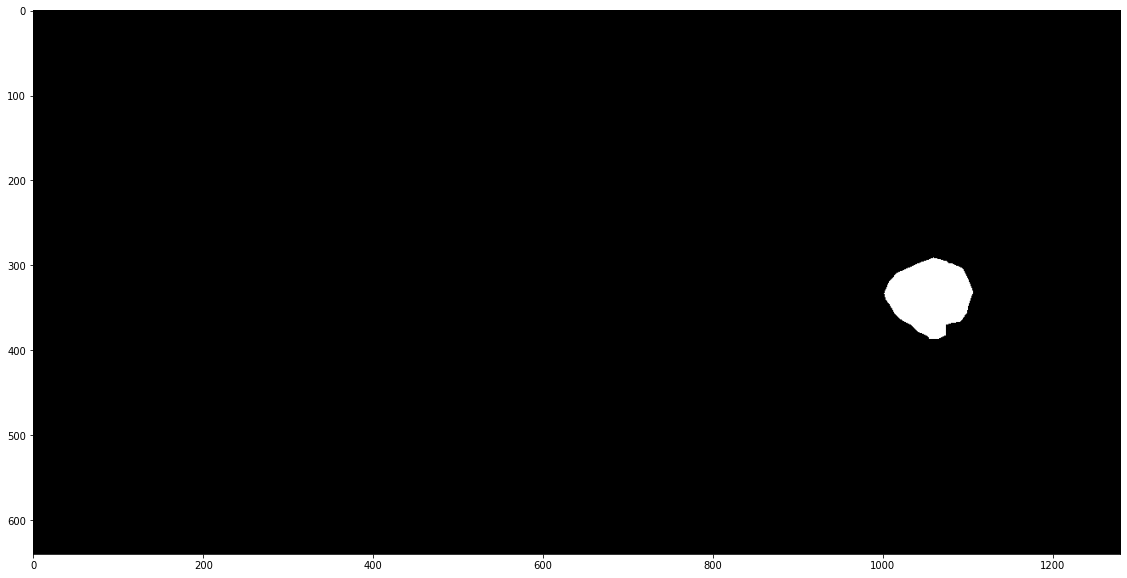

In [374]:
am_mask = (amazon_region.mask(lon, lat).values==0) & (~np.isnan(proc.fwi[0]))
plt.imshow(am_mask, cmap='gray')

In [293]:
siberia_bound = [[65.83681,69.15699],[67.37145,64.66536],[58.50049,51.4525],[61.34519,51.04077],[61.71949,53.58602],[71.11447,55.4201],[77.40275,53.69831],[85.03851,50.25473],[91.51394,50.81619],[98.2888,50.85362],[101.80724,51.75194],[108.61954,49.80557],[117.19106,49.76814],[120.41006,53.47373],[125.08883,53.21172],[127.67152,50.36702],[134.78326,48.19607],[131.52683,44.67763],[131.52683,43.06813],[135.0827,43.62959],[141.74528,46.09998],[148.85702,43.92903],[166.6738,58.48938],[190.66656,64.77765],[191.37773,68.37095],[178.65146,73.16202],[142.34416,77.87823],[90.7279,82.81902],[75.86811,81.50896],[66.47313,71.58995],[65.83681,69.15699]]

In [294]:
siberia_region = regionmask.Regions([siberia_bound], names=["siberia"], abbrevs=["S"], name="reg")

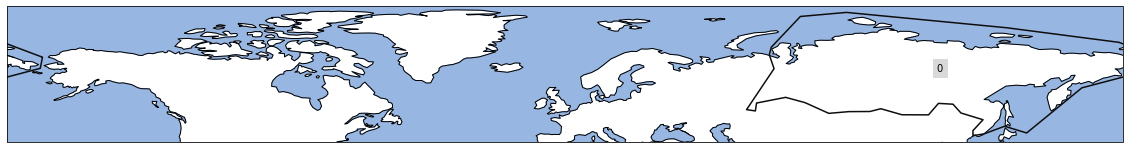

In [295]:
siberia_region.plot()

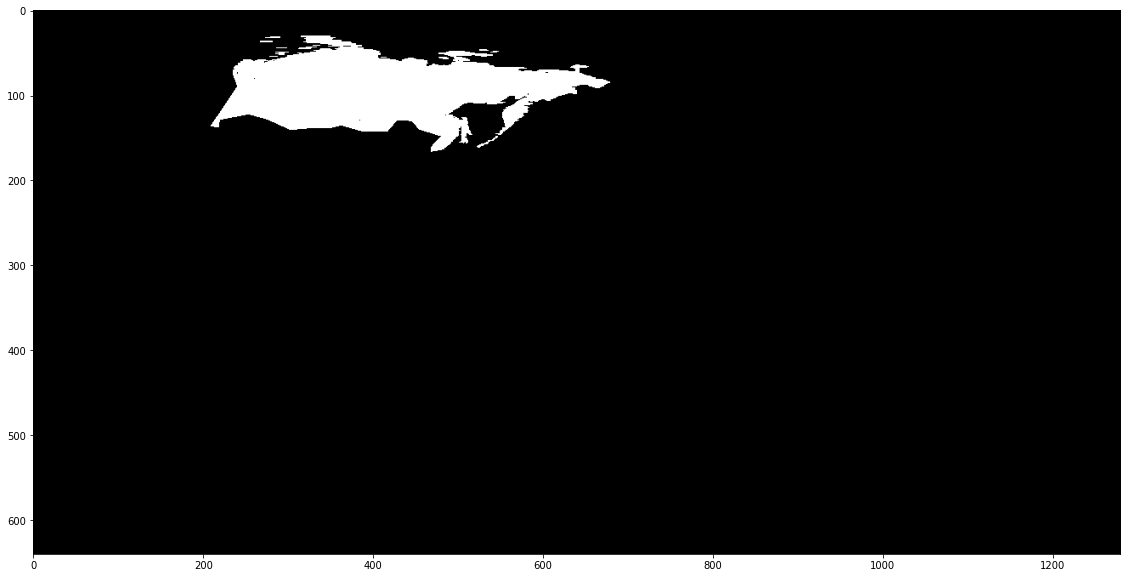

In [375]:
sb_mask = (siberia_region.mask(lon, lat).values==0) & (~np.isnan(proc.fwi[0]))
plt.imshow(sb_mask, cmap='gray')

### Stats for FWI > 10 during 2-month Australian bushfire peak

Selecting data for two months, December and January, 2019.

In [6]:
peaked = proc.sel(time=slice(np.datetime64("2019-12-01"), np.datetime64("2020-01-31")))

In [14]:
peaked_val = peaked.fwi.values[peaked.fwi.values>10]

In [15]:
npstats(peaked_val)

mean 40.742332
mad 20.210274
var 592.4607
min 10.000005
max 230.67097


### Frequency distribution for Class-Balanced Loss during 2-month Australian bushfire peak

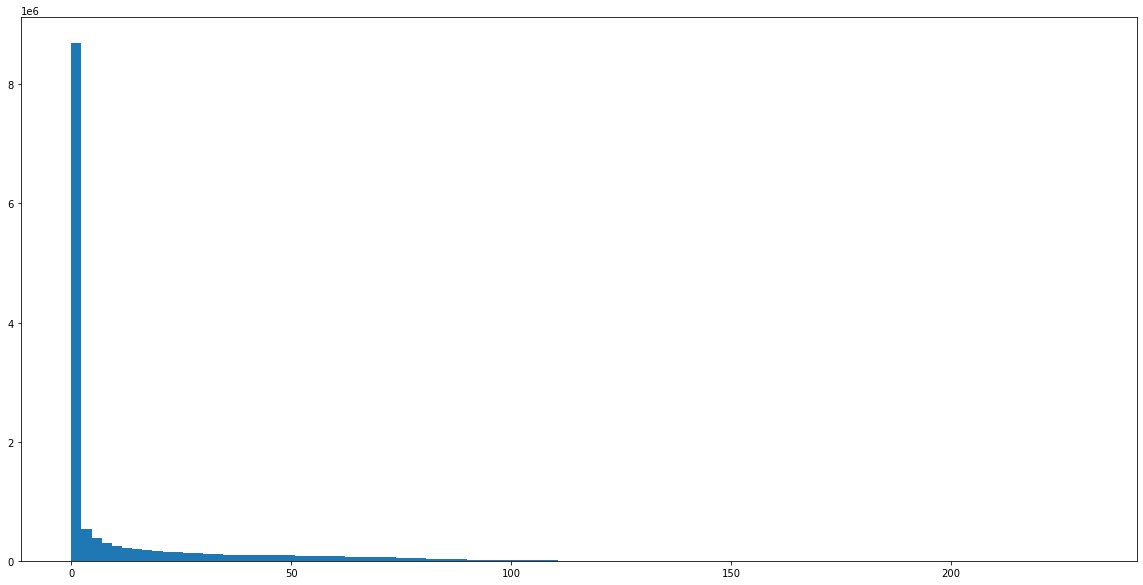

In [17]:
freq, bin_range, _ = plt.hist(peaked.fwi.values[~np.isnan(peaked.fwi.values)].flatten(), bins=100)
# Calculating center points for bin ranges
bin_points = (bin_range[1:] + bin_range[:-1]) / 2

In [18]:
bin_points

array([  1.1533549,   3.4600646,   5.766774 ,   8.073484 ,  10.380194 ,
        12.686903 ,  14.993614 ,  17.300323 ,  19.607033 ,  21.913742 ,
        24.220451 ,  26.527163 ,  28.833872 ,  31.140583 ,  33.447292 ,
        35.754    ,  38.06071  ,  40.36742  ,  42.67413  ,  44.98084  ,
        47.28755  ,  49.59426  ,  51.90097  ,  54.20768  ,  56.51439  ,
        58.8211   ,  61.127808 ,  63.434517 ,  65.74123  ,  68.04794  ,
        70.354645 ,  72.66136  ,  74.96806  ,  77.27478  ,  79.58148  ,
        81.8882   ,  84.1949   ,  86.50162  ,  88.80832  ,  91.115036 ,
        93.42174  ,  95.728455 ,  98.03517  , 100.34187  , 102.64859  ,
       104.95529  , 107.26201  , 109.56871  , 111.87543  , 114.18213  ,
       116.488846 , 118.79555  , 121.102264 , 123.408966 , 125.71568  ,
       128.0224   , 130.3291   , 132.6358   , 134.94252  , 137.24924  ,
       139.55594  , 141.86264  , 144.16936  , 146.47607  , 148.78278  ,
       151.08948  , 153.39621  , 155.70291  , 158.00961  , 160.3

In [19]:
freq

array([8.692202e+06, 5.327460e+05, 3.758320e+05, 2.985010e+05,
       2.502710e+05, 2.180800e+05, 1.957780e+05, 1.808690e+05,
       1.669160e+05, 1.532840e+05, 1.418490e+05, 1.309570e+05,
       1.227540e+05, 1.159780e+05, 1.098090e+05, 1.049090e+05,
       1.004000e+05, 9.619700e+04, 9.393900e+04, 9.194100e+04,
       9.104500e+04, 8.903300e+04, 8.684700e+04, 8.424800e+04,
       8.079200e+04, 7.840300e+04, 7.527600e+04, 7.205800e+04,
       6.781200e+04, 6.448800e+04, 6.035300e+04, 5.618900e+04,
       5.134700e+04, 4.559800e+04, 4.037800e+04, 3.583200e+04,
       3.145200e+04, 2.738700e+04, 2.349800e+04, 2.010900e+04,
       1.741800e+04, 1.519000e+04, 1.275600e+04, 1.073700e+04,
       8.911000e+03, 7.189000e+03, 6.072000e+03, 5.194000e+03,
       4.441000e+03, 3.639000e+03, 2.993000e+03, 2.601000e+03,
       2.135000e+03, 1.718000e+03, 1.350000e+03, 1.038000e+03,
       8.600000e+02, 6.920000e+02, 5.790000e+02, 5.210000e+02,
       4.310000e+02, 3.520000e+02, 2.710000e+02, 2.5300